In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.optimize import curve_fit

### Helper functions

In [2]:
def haversine_distance(point_a, point_b):
    """
    Calculate the distance between two points on the Earth (specified in decimal degrees)
    using the Haversine formula.

    Args:
        point_a (lat_a, lon_a)
        point_b (lat_b, lon_b)
    Returns:
        float: Distance in meters.
    """
    lat1, lon1, lat2, lon2 = point_a[0], point_a[1], point_b[0], point_b[1]
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Radius of earth in kilometers. Use 6371 for km. Use 6371000 for meters
    km = 6371000
    return km * c

In [ ]:
def is_in_vilnius_rough(latitude, longitude):
    """
    Roughly checks if a given point (latitude, longitude) is within the
    geographic bounding box of Vilnius, Lithuania.

    Args:
        latitude (float): The latitude of the point.
        longitude (float): The longitude of the point.

    Returns:
        bool: True if the point is within the rough bounds, False otherwise.
    """
    # Rough Bounding Box for Vilnius City
    # Based on central coordinates (approx. 54.68 N, 25.28 E)

    # 54.75 N (North edge, e.g., Verkiai Regional Park)
    LAT_NORTH = 54.75

    # 54.60 N (South edge, e.g., near Naujininkai)
    LAT_SOUTH = 54.60

    # 25.40 E (East edge, e.g., near Naujoji Vilnia)
    LON_EAST = 25.40

    # 25.15 E (West edge, e.g., near Pilaitė)
    LON_WEST = 25.15

    # Check if the latitude and longitude fall within the defined ranges
    is_lat_ok = (latitude <= LAT_NORTH) and (latitude >= LAT_SOUTH)
    is_lon_ok = (longitude <= LON_EAST) and (longitude >= LON_WEST)

    return is_lat_ok and is_lon_ok

###

### Proxy for traffic - road classification (from official Vilnius Municipality Records)

The goal is to estimate potential proportion of visitors in a particular object based on the surrounding streets and their types (rough proxy for data that is expensive to buy).

Road class type weights, in **weights** are simulated with GenAI and individual research (proxy)

In [ ]:
points_of_interest = pd.read_json('ESTIMATES.jsonl', lines = True)   
df_pois = pd.DataFrame(points_of_interest)  # if it's already in-memory
df_pois = df_pois.drop_duplicates()
df_pois = df_pois.reset_index().rename(columns={"index": "id"})

# ---------- 1) Build POI GeoDataFrame (points) ----------
gdf_pois = gpd.GeoDataFrame(
    df_pois,
    geometry=gpd.points_from_xy(df_pois["lon"], df_pois["lat"]),
    crs="EPSG:4326",
)
gdf_pois.value_counts(subset = ['name', 'lat', 'lon'])

# ---------- 2) Load streets (already WGS84) ----------
valid = ['A1','A2','B1','B2','C1','C2','D1','D2','D3','Ds','Dsb']
streets = gpd.read_file("vilnius_streets.geojson")
streets = streets[streets["KATEGOR"].isin(valid)].copy()
streets = streets[~streets["PAV"].isin([None])].copy()

# ---------- 3) Reproject to meters ----------
CRS_METERS = "EPSG:3346"
pois_m = gdf_pois.to_crs(CRS_METERS)
streets_m = streets.to_crs(CRS_METERS).explode(index_parts=False).reset_index(drop=True)

# ---------- 4) Create a separate buffer geometry for join ----------
pois_m["buffer300"] = pois_m.geometry.buffer(300)
pois_buf = pois_m.set_geometry("buffer300")  # temporary geometry for the sjoin

# ---------- 5) Spatial join: ALL streets intersecting each POI buffer ----------
joined = gpd.sjoin(
    streets_m[["GAT_KODAS", "geometry", "OBJECTID", "PAV", "KATEGOR", "DANGA"]],
    pois_buf[["id", "name", "buffer300", "geometry", "lat", "lon", "avg_people_30min_plus"]].set_geometry("buffer300"),
    how="inner",
    predicate="intersects",
)
joined = joined.rename(columns={
    "geometry": "street_geom",
}).merge(
    pois_m[["id", "geometry"]].rename(columns={"geometry": "poi_point"}),
    on="id",
    how="left",
)

##### STREET CLASSIFICATION WEIGHTS #####
weights = {
    "A1":1.00,"A2":0.90,
    "B1":0.70,"B2":0.60,
    "C1":0.45,"C2":0.35,
    "D1":0.22,"D2":0.16,"D3":0.12,"Ds":0.10,"Dsb":0.08
}

# ---------- 6) Distance from POI point to street line (meters) ----------
joined = joined.set_geometry("street_geom")
joined["dist_m"] = joined.apply(lambda r: r["poi_point"].distance(r["street_geom"]), axis=1)

# ---------- 7) Save result ----------
out = gpd.GeoDataFrame(
    joined[
        ["GAT_KODAS", "id", "name", "OBJECTID", "PAV", "KATEGOR", "DANGA", "dist_m", "street_geom", "lat", "lon", "avg_people_30min_plus"]
    ],
    geometry="street_geom",
    crs=CRS_METERS,
).to_crs("EPSG:4326")

In [ ]:
keys = ["id", "GAT_KODAS"]
out["class_w"] = out["KATEGOR"].map(weights)
out_best = (
    out.sort_values(keys + ["class_w", "dist_m"], ascending=[True, True, False, True])
      .drop_duplicates(subset=keys, keep="first")
      .reset_index(drop=True)
)

In [ ]:
g = out_best[["id", "name", "KATEGOR"]].copy()
g["w"] = g["KATEGOR"].map(weights)
poi_index = (
    g.groupby("id")
     .agg(visitors_by_car=("w", "mean"),
          n_streets=("w", "size"))
     .reset_index()
)
poi_index = g[["id","name"]].drop_duplicates().merge(poi_index, on="id", how="right")
poi_master = (
    out[["id", "lat", "lon", "avg_people_30min_plus"]]
      .drop_duplicates(subset=["id"])
)

poi_updated_dataset = (
    poi_index.merge(poi_master, on="id", how="left")
             [["id","name","lat","lon","avg_people_30min_plus",
               "visitors_by_car","n_streets"]]
).drop(columns = ['id'])


### Importing locations of existing EV charger stations
We do this account for the usage of specific stations as an indicator for intrinsic need for EV charger stations in particular locations of the city (this data is simulated, yet we are sure actual data exists). The simulation is done with a distribution that is centered around hotspots.

In [ ]:
df = pd.read_excel('stations.xlsx')
vilnius_stations = df.loc[df.apply(lambda x: is_in_vilnius_rough(x['Įkrovimo stotelės/prieigos GWS X koordinatės'], x['Įkrovimo stotelės/prieigos GWS Y koordinatės']), axis=1)].copy()
vilnius_stations['coords'] = vilnius_stations.apply(lambda x: [x['Įkrovimo stotelės/prieigos GWS X koordinatės'], x['Įkrovimo stotelės/prieigos GWS Y koordinatės']], axis=1)
vilnius_stations = (
    vilnius_stations.groupby(["Įkrovimo stotelės/prieigos vieta"], as_index=False, dropna=False)
      .agg({"Įkrovimo prieigoje esančių jungčių skaičius": "sum", "coords" : "first"})
)
vilnius_stations.columns = ['address', 'num_chargers', 'coords']

In [ ]:
# --- list of Vilnius hotspots ---
# (lat, lon, weight, influence_scale_m, hotness)
HOTSPOTS = [
    (54.6869, 25.2873, 1.00, 2500, 1.2),  # Cathedral/Old Town
    (54.6940, 25.2700, 0.80, 2200, 1.3),  # Konstitucijos pr. business area
    (54.6690, 25.2840, 0.60, 1800, 1.0),  # Train/Bus station
    (54.6430, 25.2790, 0.55, 2500, 0.8),  # Airport
    (54.7090, 25.2620, 0.70, 2200, 1.2),  # Ozas/Arena/Akropolis
    (54.7520, 25.3040, 0.50, 2500, 1.0),  # Santaros clinics
    (54.6716, 25.3069, 0.55, 1800, 1.0),  # Paupys
    (54.7244, 25.2858, 0.50, 2200, 0.8),  # Ogmios/Outlet Park
    (54.6899, 25.2544, 0.45, 1800, 0.9),  # Panorama mall
    (54.7066, 25.1767, 0.35, 2200, 0.8),  # Pilaitė
    (54.7239, 25.3363, 0.45, 2200, 1.0),  # Saulėtekis campus
]

def _seeded_noise(lat, lon, scale=0.03):
    s = f"{round(float(lat),6)}|{round(float(lon),6)}"
    rng = np.random.default_rng(abs(hash(s)) % (2**32))
    return (rng.random() - 0.5) * 2 * scale

# --- single-point version ---
def simulate_ev_usage_point(lat: float, lon: float) -> float:
    """Simulate EV station usage in [0,1] using per-hotspot hotness factors."""
    score = 0.0
    for hlat, hlon, w, sigma, hotness in HOTSPOTS:
        d = haversine_distance(lat, lon, hlat, hlon)
        score += (w * hotness) * np.exp(-(d / sigma)**2)

    # City-center distance penalty (fade at outskirts)
    c_lat, c_lon = HOTSPOTS[0][:2]
    d_center = haversine_distance(lat, lon, c_lat, c_lon)
    score *= (np.exp(-(d_center / 12_000)**2) * 1.2 + 0.2)
    score = score + _seeded_noise(lat, lon, 0.03)
    score = 1 - np.exp(-max(score, 0))
    return float(np.clip(score, 0.0, 1.0))

# --- vectorized for DataFrames ---
def simulate_ev_usage_df(df: pd.DataFrame, out_col="ev_usage") -> pd.DataFrame:
    coords = np.array(df['coords'].tolist())
    lats, lons = coords[:, 0], coords[:, 1]
    score = np.zeros(len(df), dtype=float)

    for hlat, hlon, w, sigma, hotness in HOTSPOTS:
        d = haversine_distance((lats, lons), (hlat, hlon))
        score += (w * hotness) * np.exp(-(d / sigma)**2)

    c_lat, c_lon = HOTSPOTS[0][:2]
    d_center = haversine_distance((lats, lons), (c_lat, c_lon))
    score *= (np.exp(-(d_center / 12_000)**2) * 1.2 + 0.2)
    score += np.array([_seeded_noise(la, lo, 0.03) for la, lo in zip(lats, lons)])

    score = 1 - np.exp(-np.maximum(score, 0))
    df = df.copy()
    df[out_col] = np.clip(score, 0.0, 1.0)
    return df


In [ ]:
vilnius_stations = simulate_ev_usage_df(vilnius_stations)

### Individual EV charger station rating calculation 

This is done accounting for the average attendance in POIs (estimated with gen ai), traffic-proxy (above), current ev station usage. It is a reasonable heuristic to display the potential rating for the need for EV charging stations in particular spots. Higher number indicates higher need.

In [ ]:
def walking_acceptance_function(x):
    """
    Calculates the walking acceptance factor based on distance x (in meters).
    The function is 1 for 0-200m and decreases smoothly to 0 at 500m.

    The mathematical function is:
    f(x) = 1,                              if 0 <= x <= 200
    f(x) = 0.5 * (cos(pi * (x - 200) / 300) + 1), if 200 < x < 500
    f(x) = 0,                              if x >= 500
    """

    conditions = [
        x <= 200,
        (x > 200) & (x < 500),
        x >= 500
    ]
    transition_function = 0.5 * (np.cos(np.pi * (x - 200) / 300) + 1)
    values = [
        1,
        transition_function,
        0
    ]
    return np.select(conditions, values)

In [ ]:
vilnius_cars = 429853 # 2024 metu duomenimis
vilnius_ev_cars = 16016 + 2318 # 2025 metu duomenimis vilniaus miestas + rajonas

def supply_demand_function(df, daily_visitors, visitors_by_car):
    demand = (df['ev_usage'] * df['walking_acceptance'] * df['num_chargers']).sum() * (daily_visitors * visitors_by_car * (vilnius_ev_cars/vilnius_cars)) 
    if demand == 0:
        demand = (daily_visitors * visitors_by_car * (vilnius_ev_cars/vilnius_cars)) 
    supply = (df['num_chargers'] * df['walking_acceptance']).sum()
    ev_charger_rating = demand / (supply + 1)
    return ev_charger_rating


In [ ]:
individual_ev_charger_ratings = []
for _, point in poi_updated_dataset.iterrows():
    _stations = vilnius_stations.copy()
    _stations['distance'] = _stations['coords'].apply(lambda x: haversine_distance(x, (point['lat'], point['lon'])))
    _stations['walking_acceptance'] = _stations['distance'].apply(lambda x: walking_acceptance_function(x))
    individual_ev_charger_rating = supply_demand_function(_stations, point['avg_people_30min_plus'], point['visitors_by_car'])
    print(f'{point["name"]}. Rating: {individual_ev_charger_rating:.2f}')
    individual_ev_charger_ratings.append(individual_ev_charger_rating)
poi_updated_dataset['individual_ev_charger_rating'] = individual_ev_charger_ratings


Lietuvos Respublikos žemės ūkio ministerija + Lietuvos Respublikos susisiekimo ministerija + Vilniaus Mažasis Teatras + Lietuvos žemės ūkio biblioteka. Rating: -0.64
Vilniaus paveikslų galerija + Chodkevičių rūmai + Lietuvos dailės muziejus. Rating: -0.87
PC „Europa“ + Iki + Lemon Gym. Rating: -0.91
GO9 + Lidl + GymPlius. Rating: 1.69
Vilniaus universitetas + Vilniaus universiteto biblioteka + VU kiemo teatras. Rating: 0.40
Sapiegų rūmai + Teismų ekspozicija. Rating: -0.84
AB Pieno žvaigždės + TRIO verslo centras. Rating: -0.93
T parkas + Automuziejus Vilnius + GymPlius. Rating: -0.35
VU Tarptautinių santykių ir politikos mokslų institutas + Iliuzijų muziejus + Vilniaus muziejus. Rating: -0.84
Green Hall 1 + Green Hall 3. Rating: -0.77
PC „Mandarinas“ + Hyper RIMI „Mandarinas“. Rating: -0.64
Forum Cinemas Vingis + Domino teatras. Rating: -0.79
Jogos studija „OM“ + Sport Spot. Rating: -0.88
PC Žali + Iki. Rating: 14.94
Evolution office system + Maxima X. Rating: -0.74
CUP + Maxima X. Ra

In [ ]:
poi_updated_dataset.sort_values(by='individual_ev_charger_rating', ascending=False)

,name,lat,lon,avg_people_30min_plus,visitors_by_car,n_streets,individual_ev_charger_rating
233,Promo Cash&Carry,54.621203,25.155306,1000,0.900000,1,38.386611
312,Vilniaus Gedimino technikos universitetas,54.722023,25.336339,3500,0.306667,3,37.232276
292,Mykolo Romerio Universitetas,54.734153,25.258561,2500,0.346667,3,36.964885
33,Vilniaus universiteto Teisės fakultetas + Viln...,54.722265,25.333133,2500,0.285000,2,30.389401
344,Respublikinė Vilniaus psichiatrijos ligoninė,54.683699,25.417767,1500,0.450000,1,28.789958
...,...,...,...,...,...,...,...
187,HERO,54.696613,25.280849,900,0.267000,10,-0.973720
451,Mažoji burė,54.696549,25.279779,900,0.278889,9,-0.974318
478,LR ginklų fondas prie VRM,54.706393,25.270761,300,0.388333,6,-0.977561
400,FLOW,54.695865,25.280175,700,0.267000,10,-0.978257


### Grouped EV ratings

The goal is to address the fact that objects in proximity have an compounding effect on the total need for EV charging station on each other (people mya use nearby stations) even when visiting other objects. This is done by weighing by distance from the object.

In [ ]:
R = 500  # radius in meters
gdf = gpd.GeoDataFrame(
    poi_updated_dataset,
    geometry=gpd.points_from_xy(poi_updated_dataset["lon"], poi_updated_dataset["lat"]),
    crs="EPSG:4326"
).to_crs("EPSG:3346")  # project to meters (LKS94)


sindex = gdf.sindex
results = []

In [ ]:

sindex = gdf.sindex
results = []

for idx, row in gdf.iterrows():
    geom = row.geometry
    possible = list(sindex.intersection(geom.buffer(R).bounds))
    nearby = gdf.iloc[possible].copy()
    nearby["dist"] = nearby.geometry.distance(geom)
    nearby = nearby[nearby["dist"] <= R]
    nearby["weight"] = walking_acceptance_function(nearby["dist"])
    weighted_sum = (nearby["individual_ev_charger_rating"] * nearby["weight"]).sum()
    results.append(weighted_sum)

gdf["ev_rating_within_circle"] = results

In [ ]:
gdf.sort_values(by='ev_rating_within_circle', ascending=False).head(10)

,name,lat,lon,avg_people_30min_plus,visitors_by_car,n_streets,individual_ev_charger_rating,geometry,ev_rating_within_circle
335,Vaikų ligoninė,54.755323,25.278465,1500,0.270000,4,17.273975,POINT (582292.657 6069528.387),85.380643
355,Vaiko raidos centras ir pediatrijos I korpusas,54.755968,25.282588,1400,0.286667,3,17.117585,POINT (582556.721 6069605.012),82.195006
33,Vilniaus universiteto Teisės fakultetas + Viln...,54.722265,25.333133,2500,0.285000,2,30.389401,POINT (585881.179 6065914.984),80.822783
476,Respublikinė tuberkuliozės ir infekcinių ligų ...,54.756679,25.279237,1000,0.270000,4,11.515983,POINT (582339.588 6069680.221),80.135718
363,Santariškių klinikų vaikų ligoninė,54.755073,25.282862,1500,0.270000,4,17.273975,POINT (582576.131 6069505.821),78.523551
312,Vilniaus Gedimino technikos universitetas,54.722023,25.336339,3500,0.306667,3,37.232276,POINT (586088.237 6065891.981),77.895267
307,Vilniaus universiteto Ekonomikos fakultetas,54.722209,25.332103,1200,0.285000,2,10.365569,POINT (585815.011 6065907.548),75.961625
368,Vaikų pediatrijos II korpusas,54.756088,25.283888,1200,0.236000,5,12.078987,POINT (582640.142 6069619.931),69.110324
339,Vilniaus universiteto Fizikos fakultetas,54.722219,25.331048,1200,0.230000,3,3.021362,POINT (585746.966 6065907.393),64.742592
96,uniPark automobilių parkingas P9,54.755315,25.276841,450,0.285000,2,5.470092,POINT (582188.126 6069525.593),63.509633


In [ ]:
# Convert back to WGS84 (EPSG:4326) if you want lat/lon coordinates
gdf_out = gdf.to_crs("EPSG:4326")

gdf_out.to_file("poi_with_ev_circle.geojson", driver="GeoJSON")

print("✅ Saved → poi_with_ev_circle.geojson")


✅ Saved → poi_with_ev_circle.geojson


### Additional graph - exponential fit for increase in EV cars in Vilnius

In [ ]:
lithuania_ev_cars = pd.DataFrame({
    "date": [
        "2020-01-01", "2020-04-01", "2020-07-01", "2020-10-01",
        "2021-01-01", "2021-04-01", "2021-07-01", "2021-10-01",
        "2022-01-01", "2022-04-01", "2022-07-01", "2022-10-01",
        "2023-01-01", "2023-04-01", "2023-07-01", "2023-10-01",
        "2024-01-01", "2024-04-01", "2024-07-01", "2024-10-01",
        "2025-01-01", "2025-04-01", "2025-07-01", "2025-10-01"
    ],
    "total_ev_cars": [
        2606, 2972, 3366, 3985,
        4502, 4929, 5807, 6912,
        8255, 9240, 10372, 11459,
        12510, 13692, 15531, 17406,
        19435, 21352, 23476, 26016,
        28812, 31750, 35537, 40276
    ]
})

lithuania_ev_cars["date"] = pd.to_datetime(lithuania_ev_cars["date"])

Exponential fit: y = 3336.6 · e^(0.433·t)
2025-10-01 → Lithuania: 40,276, Vilnius: 18,334
2026-10-01 → Predicted Lithuania: 61,819, Predicted Vilnius: 28,140


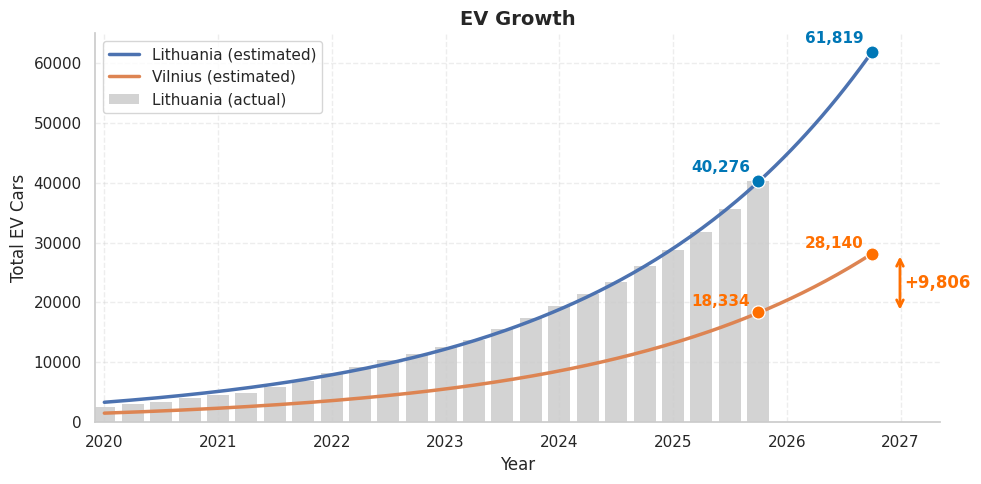

In [ ]:
K = vilnius_ev_cars / lithuania_ev_cars.iloc[-1, 1]  # Vilnius share

lithuania_ev_cars["date"] = pd.to_datetime(lithuania_ev_cars["date"])
t = (lithuania_ev_cars["date"] - lithuania_ev_cars["date"].min()).dt.days / 365.25
y = lithuania_ev_cars["total_ev_cars"].values

def exp_growth(t, a, b):
    return a * np.exp(b * t)

a, b = curve_fit(exp_growth, t, y, p0=(2000, 0.5))[0]

# Predict full curve
t_future = np.linspace(0, t.max() + 1.0, 200)
dates_future = lithuania_ev_cars["date"].min() + pd.to_timedelta(t_future * 365.25, unit="D")
y_fit_lt = exp_growth(t_future, a, b)
y_fit_vilnius = K * y_fit_lt

# Predicted at 2026-10-01
date_2026 = pd.Timestamp("2026-10-01")
t_2026 = (date_2026 - lithuania_ev_cars["date"].min()).days / 365.25
y_pred_lt = exp_growth(t_2026, a, b)
y_pred_vilnius = K * y_pred_lt

fit_df = pd.DataFrame({
    "date": np.concatenate([dates_future, dates_future]),
    "value": np.concatenate([y_fit_lt, y_fit_vilnius]),
    "series": (["Lithuania (estimated)"] * len(dates_future)) +
              ([f"Vilnius (estimated)"] * len(dates_future))
})
hist_points = lithuania_ev_cars.assign(series="Lithuania (actual)") \
                               .rename(columns={"total_ev_cars": "value"})

# --- Plot ---
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(
    hist_points["date"], hist_points["value"],
    width=pd.Timedelta("70D"), color="lightgrey", edgecolor="none",
    label="Lithuania (actual)", zorder=0
)
sns.lineplot(data=fit_df, x="date", y="value", hue="series", linewidth=2.5, ax=ax)

date_2025 = pd.Timestamp("2025-10-01")
lt_2025 = lithuania_ev_cars.loc[lithuania_ev_cars["date"] == date_2025, "total_ev_cars"].iloc[0]
vil_2025 = vilnius_ev_cars
lt_2026 = y_pred_lt
vil_2026 = y_pred_vilnius


ax.set_xlim(left=lithuania_ev_cars["date"].min() - pd.Timedelta(days=30),
            right=date_2026 + pd.Timedelta(days=220))

x_bracket_vil = date_2026 + pd.Timedelta(days=90)
diff_vil = int(vil_2026 - vil_2025)

ax.annotate(
    "", xy=(x_bracket_vil, vil_2025), xytext=(x_bracket_vil, vil_2026),
    arrowprops=dict(arrowstyle="<->", lw=2, color="#ff6f00"),
    annotation_clip=False
)

ax.text(
    x_bracket_vil + pd.Timedelta(days=15),
    (vil_2025 + vil_2026) / 2,
    f"+{diff_vil:,}",
    color="#ff6f00", fontsize=12, weight="bold", va="center", ha="left"
)

for d, lt, vil in [(date_2025, lt_2025, vil_2025), (date_2026, lt_2026, vil_2026)]:
    ax.scatter(d, lt,  s=90, color="#0077b6", edgecolor="white", linewidth=0.9, zorder=10)
    ax.scatter(d, vil, s=90, color="#ff6f00", edgecolor="white", linewidth=0.9, zorder=10)

offset = pd.Timedelta(days=-120)
ax.text(date_2025 + offset, lt_2025 + 1500, f"{int(lt_2025):,}", color="#0077b6",
        fontsize=11, ha="center", weight="bold")
ax.text(date_2026 + offset, lt_2026 + 1500, f"{int(lt_2026):,}", color="#0077b6",
        fontsize=11, ha="center", weight="bold")
ax.text(date_2025 + offset, vil_2025 + 1000, f"{int(vil_2025):,}", color="#ff6f00",
        fontsize=11, ha="center", weight="bold")
ax.text(date_2026 + offset, vil_2026 + 1000, f"{int(vil_2026):,}", color="#ff6f00",
        fontsize=11, ha="center", weight="bold")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.set_title("EV Growth", fontsize=14, weight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Total EV Cars")
ax.legend(title=None)
sns.despine()
ax.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.savefig("ev_growth_with_projections.png", dpi=300)

print(f"Exponential fit: y = {a:.1f} · e^({b:.3f}·t)")
print(f"2025-10-01 → Lithuania: {lt_2025:,}, Vilnius: {vil_2025:,}")
print(f"2026-10-01 → Predicted Lithuania: {int(lt_2026):,}, Predicted Vilnius: {int(vil_2026):,}")
